### Imports and CUDA

In [21]:
# Matplotlib
import requests
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn

import pandas as pd

In [22]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Objective

#### To develop a model that predicts taxi availability within a specific area for the next three hours. This means that if the model is run at 12 PM, it will provide predicted taxi availability for 1 PM, 2 PM, and 3 PM.

The area of interest is defined by the following geographical boundaries:

    North: 1.35106
    South: 1.32206
    East: 103.97839
    West: 103.92805

To identify the taxis currently available within this region, we use the TaxiAvailabilityScript.py.

This script collects real-time data, which serves as input for our predictive model.

By leveraging historical taxi availability trends and real-time data, our model aims to provide accurate forecasts, helping commuters, ride-hailing services, and urban planners make informed decisions.


# **To-Do List for Taxi Availability Prediction**

## **Step 1: Cleaning the Taxi Availability Data**
The first step involves retrieving and preprocessing the taxi availability dataset. The dataset consists of the following columns:

1. **DateTime**  
2. **Taxi Available Throughout Singapore**  
3. **Taxi Available in Selected Box Area**  
4. **Coordinates[]**  

For our specific use case, **the coordinates column will not be used for now**.  

To prepare the data for the neural network:  
- **Inputs:** We will use `DateTime` and `Taxi Available Throughout Singapore` as features.  
- **Output:** `Taxi Available in Selected Box Area` will be the target variable.  
- **DateTime Conversion:** Since `DateTime` is not in a format suitable for neural networks, we will extract relevant features:
  - **IsWeekend**: A binary feature (1 if it's a weekend, 0 otherwise).  
  - **Hour**: Transformed into a numerical value between **1 and 24** (avoiding 0, which may cause training issues).  

---

## **Step 2: Adding Additional Features**  
*(Partially completed; will be refined over time)*  

Aside from the existing columns, we aim to incorporate additional features that may improve prediction accuracy:  

1. **ERP Rates (Electronic Road Pricing) at the given time and location**  
   - Uncertain if this will significantly impact predictions. Further analysis is needed.  

2. **Number of LTA (Land Transport Authority) gantry locations**  
   - Again, its usefulness remains uncertain—further evaluation required.  

3. **Traffic Incidents in the Selected Area**  
   - A script (`TrafficIncidentScript.py`) has been written to update `traffic_incident.csv` with the latest traffic incidents.  
   - Over time, as the dataset grows, we hope this feature will become useful.  

4. **Number of Taxi Stands in the Area**  
   - Currently **not useful** because our area of interest is fixed.  
   - However, if we allow dynamic selection of areas in the future, this could become relevant.  

5. **Temperature at a Given Time and Date** *(To be implemented)*  

6. **Rainfall Data** *(To be implemented)*  

To ensure all features align properly, we will **synchronize all datasets based on DateTime** before feeding them into the model.  

---

## **Step 3: Creating the Training-Test Split**  
- Initially, we will perform an **80/20 Training-Test split** for simplicity.  
- In the future, we may introduce a **Training-Validation-Test split** to further refine model performance.  

---

## **Step 4: Building the Model**  
We will begin with an **LSTM model**, as LSTMs are well-suited for time-series forecasting.  
- **Initial Limitation:** The model, in its basic form, will only predict the next hour.  
- **Future Improvement:** A **sliding window approach** will be explored and implemented to extend predictions further.  

---

## **Step 5: Model Evaluation and Improvement**  
- After the initial model is trained, we will assess its performance.  
- Based on results, we will explore potential improvements, such as hyperparameter tuning, architectural modifications, or additional feature engineering.  

---

This structured approach will guide the development of a robust and accurate taxi availability prediction model. 🚖💡


## **Preparing the taxi_availability data here.**

Normalization of certain inputs are done as well, but I am unsure if it is the right thing to do as well.

In [23]:
# weather_file_path = "merged_weather.csv"
# weather_df = pd.read_csv(weather_file_path, delimiter=",")

# weather_df = weather_df[::-1]


In [24]:
# taxi_availability_file_path = "taxi_availability.csv"

# taxi_df = pd.read_csv(taxi_availability_file_path, delimiter=",")

merged_weather_taxi_df = "merged_file_3_years.csv"
taxi_df = pd.read_csv(merged_weather_taxi_df, delimiter = ",")

#Adjusting for weather parameters
taxi_df = taxi_df.drop(columns = "stationId")

#Adjusting for taxi_vailability parameters
taxi_df_coordinates = taxi_df["Coordinates[]"]
taxt_df_datetime = taxi_df["DateTime"]
taxi_df = taxi_df.drop(columns = "Coordinates[]")
taxi_df["DateTime"] = pd.to_datetime(taxi_df["DateTime"])

taxi_df["IsWeekend"] = (taxi_df["DateTime"].dt.weekday >= 5).astype(int)
taxi_df["Hour"] = taxi_df["DateTime"].dt.hour + 1  # Convert 0-23 to 1-24
taxi_df = taxi_df.drop(columns = "DateTime")

print(taxi_df.dtypes)

Taxi Available throughout SG             int64
Taxi Available in Selected Box Area      int64
temp_value                             float64
humidity_value                         float64
rainfall_value                         float64
IsWeekend                                int64
Hour                                     int32
dtype: object


### Converting all dtypes into float32

In [25]:
# taxi_df=taxi_df[:5120]
numeric_columns = taxi_df.select_dtypes(include=['int64', 'int32','float64','object']).columns
print("numeric_columns",numeric_columns)
taxi_df[numeric_columns] = taxi_df[numeric_columns].astype('float32')
numeric_columns = taxi_df.select_dtypes(include=['int64', 'int32','float64','object']).columns

# Convert selected columns to float32
taxi_df[numeric_columns] = taxi_df[numeric_columns].astype('float32')




numeric_columns Index(['Taxi Available throughout SG', 'Taxi Available in Selected Box Area',
       'temp_value', 'humidity_value', 'rainfall_value', 'IsWeekend', 'Hour'],
      dtype='object')


### Normalizing all values

In [26]:
#---------------Normalise-----------------------
# Drop 'DateTime' as it's no longer needed
# Normalize the 'Hour' and 'IsWeekend' columns (if needed)


data_min = taxi_df.min(axis=0)
data_max = taxi_df.max(axis=0)
taxi_df_normalized = (taxi_df - data_min) / (data_max - data_min)

# scaler = MinMaxScaler()
# taxi_df[["Hour", "IsWeekend", "Taxi Available throughout SG","Taxi Available in Selected Box Area"]] = scaler.fit_transform(taxi_df[["Hour", "IsWeekend","Taxi Available throughout SG","Taxi Available in Selected Box Area"]])
# taxi_df = taxi_df.apply(pd.to_numeric, errors='coerce')
taxi_df_output_normalized  = taxi_df_normalized["Taxi Available in Selected Box Area"]
taxi_df_normalized = taxi_df_normalized.drop(columns = "Taxi Available in Selected Box Area")
taxi_df_normalized.to_csv("checker.csv", index=False)  # Set index=False to exclude row numbers

# Convert to NumPy arrays
input_data = taxi_df_normalized.values  # Shape: (5120, num_features)
output_data = taxi_df_output_normalized.values  # Shape: (5120,)
# taxi_df_output = taxi_df["Taxi Available in Selected Box Area"]
# input_data = taxi_df.values  # Shape: (5120, num_features)
# output_data = taxi_df_output.values  # Shape: (5120,)

print("Input Data: ",input_data.shape)
print("Output Data: ",output_data.shape)

# Define sequence length



Input Data:  (25592, 6)
Output Data:  (25592,)


### No Normalization Style

In [27]:
# #---------------No Normalization-----------------------

# # Drop 'DateTime' as it's no longer needed
# taxi_df_no_norm = taxi_df  # Remove DateTime but keep raw values

# # Separate input and output data
# taxi_df_output_no_norm = taxi_df_no_norm["Taxi Available in Selected Box Area"]
# taxi_df_no_norm = taxi_df_no_norm.drop(columns=["Taxi Available in Selected Box Area"])

# # Save to CSV for checking
# taxi_df_no_norm.to_csv("checker_no_norm.csv", index=False)  # Set index=False to exclude row numbers

# # Convert to NumPy arrays (raw values)
# input_data = taxi_df_no_norm.values  # Shape: (5120, num_features)
# output_data = taxi_df_output_no_norm.values  # Shape: (5120,)

# print("Input Data: ", input_data.shape)
# print("Input Data: ", input_data[0])

# print("Output Data: ", output_data.shape)
# print("Input Data: ", output_data[0])


### Create Sequence Function

In [28]:
seq_length = 24
pred_horizon = 3  # Number of future time steps to predict

def create_sequences(data, labels, seq_length, pred_horizon):
    xs, ys = [], []
    for i in range(0, len(data), seq_length):  # Start from 0 and increment by seq_length
        if i + seq_length + pred_horizon <= len(data):  # Ensure enough data for prediction horizon
            xs.append(data[i:i + seq_length])  # Input sequence (continuous)
            ys.append(labels[i + seq_length : i + seq_length + pred_horizon])  # Next 3 values
    return np.array(xs), np.array(ys)


In [29]:

X, y = create_sequences(input_data, output_data, seq_length,pred_horizon)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y[:, None], dtype=torch.float32)
y = y.permute(0, 2, 1)  # Shape: (samples, pred_horizon, 1)

# Split sizes
total_samples = len(X)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

# Split the data
trainX, valX, testX = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
trainY, valY, testY = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# Create TensorDatasets
train_dataset = TensorDataset(trainX, trainY)
val_dataset = TensorDataset(valX, valY)
test_dataset = TensorDataset(testX, testY)

# DataLoaders
batch_size = 17
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Example of accessing a batch of data
for inputs, targets in train_loader:
    print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')
    break  # Only print the first batch for verification

Inputs: torch.Size([17, 24, 6]), Targets: torch.Size([17, 3, 1])


In [30]:
print("test_loader",len(test_loader))

test_loader 6


Using a bidirectional LSTM as the encoder

In [31]:
class BiEncoderLSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(BiEncoderLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_directions = 2  # Since it's bidirectional
        
        # LSTM layer
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
    def forward(self, inputs):

        out, (hn, cn) = self.lstm(inputs)
        hn_dec = hn[0] + hn[1]
        cn_dec = cn[0] + cn[1]

        hn_dec = hn_dec.unsqueeze(0)
        cn_dec = cn_dec.unsqueeze(0)

        return hn_dec, cn_dec


In [32]:
class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DecoderLSTM, self).__init__()


        self.lstm = nn.LSTM(6, hidden_size, batch_first=True)

        # Implementing Prof Idea
        self.linear1 = nn.Linear(128, 1)
        self.linearsub1 = nn.Linear(128, 6)

        self.linear2 = nn.Linear(128, 1)
        self.linearsub2 = nn.Linear(128, 6)


    def forward(self, x, hidden,):
        outputs = []
        decoder_input = x
        
        # First LSTM layer
        # print("Entering First Layer of Decoder")
        y1, hidden1 = self.lstm(decoder_input, hidden)
        linear_y1 = self.linear1(y1)
        linear_y1 = linear_y1.mean(dim=1, keepdim=True)
        linear_suby1 = self.linearsub1(y1)

        # print("Entering Second Layer of Decoder")
        # Second LSTM layer
        y2, hidden2 = self.lstm(linear_suby1, hidden)
        linear_y2 = self.linear2(y2)
        linear_suby2 = self.linearsub1(y2)
        linear_y2 = linear_y2.mean(dim=1, keepdim=True)

        # print("Entering Third Layer of Decoder")
        y3, hidden3 = self.lstm(linear_suby2, hidden)
        linear_y3 = self.linear2(y3)
        linear_y3 = linear_y3.mean(dim=1, keepdim=True)

        outputs.append(linear_y1.squeeze(1))  # shape: [17, 1]
        outputs.append(linear_y2.squeeze(1))
        outputs.append(linear_y3.squeeze(1))

        final_output = torch.stack(outputs, dim=1)  # [17, 3, 1]
        # print("linear_y1", linear_y1)

        # print("Decoder input shape: ", decoder_input.shape)
        # print("linear_y1: ", linear_y1.shape)
        # print("final_output: ", final_output.shape)
        return final_output



In [33]:
class Seq2Seq(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Seq2Seq, self).__init__()
        self.output_length = output_size
        self.encoder = BiEncoderLSTM(6, hidden_size) 
        self.decoder = DecoderLSTM(6, hidden_size) 
    def forward(self, inputs, outputs=None):

        # Encode the input sequence
        hidden = self.encoder(inputs)  # Get encoded hidden state from the encoder
        # print("Bi Encoder Hidden Shape: ", hidden[0].shape, hidden[1].shape)

        # Initialize decoder input (usually last input value or a special token)
        decoder_input = inputs
        # Decode the sequence
        output = self.decoder(decoder_input, hidden)
        return output

In [34]:
def train(dataloader, model, num_epochs, learning_rate):
    # Set the model to training mode
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_graph = []  # Initialize a list to store loss values

    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, outputs in dataloader:
            inputs = inputs.to(device)
            outputs = outputs.to(device)

            # Clear previous gradients
            optimizer.zero_grad()
            # Forward pass
            pred = model(inputs, outputs)
            # Calculate loss
            loss = criterion(pred, outputs)
            total_loss += loss.item()
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Append the average loss for this epoch to the loss_graph list
        loss_graph.append(total_loss / len(dataloader))

        # Print total loss every few epochs
        if epoch % 25 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Avg Loss: {total_loss / len(dataloader)}')

    return loss_graph  # Return the loss graph to plot it later

Epoch 1/300, Avg Loss: 0.027462230985984205
Epoch 26/300, Avg Loss: 0.005992029281333089
Epoch 51/300, Avg Loss: 0.004850522405467928
Epoch 76/300, Avg Loss: 0.004324238416738808
Epoch 101/300, Avg Loss: 0.0036732618836686015
Epoch 126/300, Avg Loss: 0.0029768294701352717
Epoch 151/300, Avg Loss: 0.002375660971738398
Epoch 176/300, Avg Loss: 0.0015238992671947926
Epoch 201/300, Avg Loss: 0.0009828367066802457
Epoch 226/300, Avg Loss: 0.0007900748628890141
Epoch 251/300, Avg Loss: 0.0003416890776134096
Epoch 276/300, Avg Loss: 0.0004588812898145989


Text(0, 0.5, 'Loss')

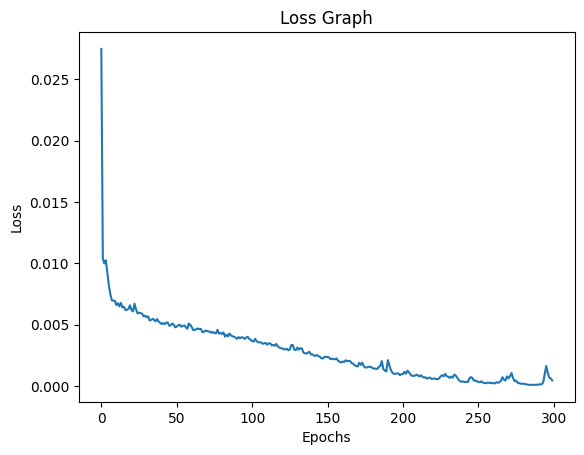

In [35]:
# Hyperparameters
input_size = 6
hidden_size = 128
output_size = 3
learning_rate = 0.001
num_epochs = 100
num_layers = 3

dataloader = train_loader

# Initialize Seq2Seq Model
seq2seq_model = Seq2Seq(hidden_size = hidden_size, output_size = output_size)

# Train the model
loss_graph = train(dataloader = dataloader, model = seq2seq_model, num_epochs = 300, learning_rate = 1e-3)
# Plot the loss graph
plt.plot(loss_graph)
plt.title("Loss Graph")
plt.xlabel("Epochs")
plt.ylabel("Loss")


In [44]:
print(len(test_loader))

6


In [43]:
# Set the model to evaluation mode
seq2seq_model.eval()

# Initialize variables to track loss
loss_value = 0
num_batches = 0

# Define the loss function
criterion = torch.nn.MSELoss()

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if batch_idx == len(test_loader) - 1:  
            break  # Skip the last batch

        # Forward pass (ensure correct hidden states are passed)
        hidden_state, cell_state = seq2seq_model.encoder(inputs)  # Get encoder hidden states
        decoder_input = inputs  # Use the input as the initial decoder input (you could also use a special token)

        # The decoder will use these hidden states
        output = seq2seq_model.decoder(decoder_input, (hidden_state, cell_state))  # Pass hidden and cell states to the decoder

        # Denormalize predictions and targets (for all 3 time steps)
        output_denorm = output * (data_max["Taxi Available in Selected Box Area"] - data_min["Taxi Available in Selected Box Area"]) + data_min["Taxi Available in Selected Box Area"]
        targets_denorm = targets * (data_max["Taxi Available in Selected Box Area"] - data_min["Taxi Available in Selected Box Area"]) + data_min["Taxi Available in Selected Box Area"]

        # Compute loss on normalized data
        loss_value += criterion(output, targets)

        # Print a sample of the normalized and denormalized values
        print("Normalized output[0]:", output[0].tolist())  
        print("Normalized target[0]:", targets[0].tolist())  
        print("Denormalized output[0]:", output_denorm[0].tolist())  
        print("Denormalized target[0]:", targets_denorm[0].tolist())  
        print("-" * 50)

# Compute average loss
loss_value = loss_value / (len(test_loader) - 1)
print("Predicted output shape:", output.shape)
print("True output shape:", targets.shape)
print(f'Average Validation Loss: {loss_value:.4f}')


Normalized output[0]: [[0.35934534668922424], [0.33387717604637146], [0.2681454122066498]]
Normalized target[0]: [[0.3498098850250244], [0.32319390773773193], [0.3650190234184265]]
Denormalized output[0]: [[95.50782775878906], [88.80970001220703], [71.5222396850586]]
Denormalized target[0]: [[93.0], [86.0], [97.0]]
--------------------------------------------------
Normalized output[0]: [[0.26787829399108887], [0.27540042996406555], [0.32952913641929626]]
Normalized target[0]: [[0.2927756607532501], [0.3041824996471405], [0.3460076153278351]]
Denormalized output[0]: [[71.45198822021484], [73.43031311035156], [87.6661605834961]]
Denormalized target[0]: [[78.0], [81.0], [92.0]]
--------------------------------------------------
Normalized output[0]: [[0.24702675640583038], [0.2813083827495575], [0.3195720613002777]]
Normalized target[0]: [[0.258555144071579], [0.35741445422172546], [0.2889733910560608]]
Denormalized output[0]: [[65.9680404663086], [74.9841079711914], [85.04745483398438]]

In [38]:

# model.eval()

# # Initialize variables to track loss
# loss_value = 0
# num_batches = 0

# # Define the loss function
# criterion = torch.nn.MSELoss()

# # Initialize hidden state and cell state
# hidden_state, cell_state = None, None  

# # Disable gradient computation for validation
# with torch.no_grad():
#     for batch_idx, (inputs, targets) in enumerate(test_loader):
#         if batch_idx == len(test_loader) - 1:  
#             break  # Skip the last batch
#         # Forward pass
#         output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)
#         print("Predicted output: ", output)
#         print("True Output: ", targets)

#         # Compute loss
#         # Compute loss
#         loss_value += criterion(output, targets)
# # Compute average loss
# loss_value = loss_value / (len(test_loader) -1 )

# # Print validation results
# print(f'Average Validation Loss: {loss_value:.4f}')
